In [34]:
# ! pip install tensorflow numpy matplotlib opencv-python


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


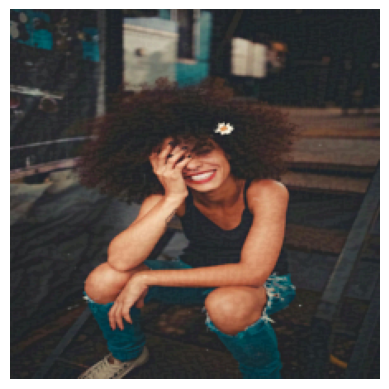

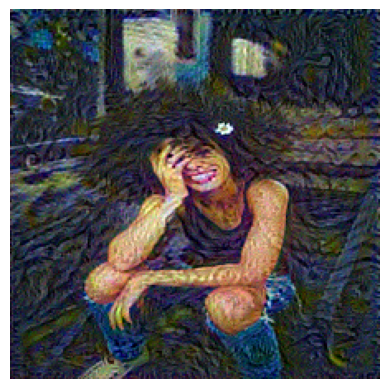

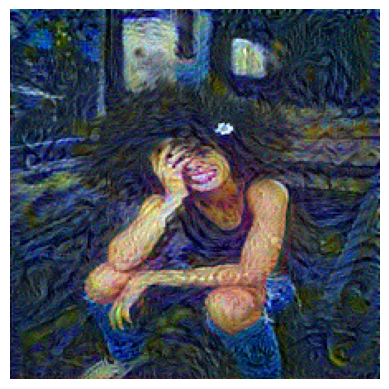

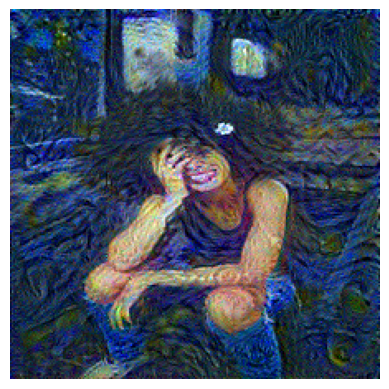

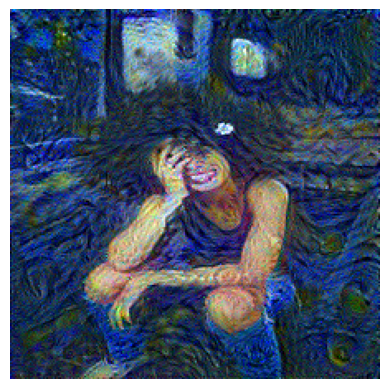

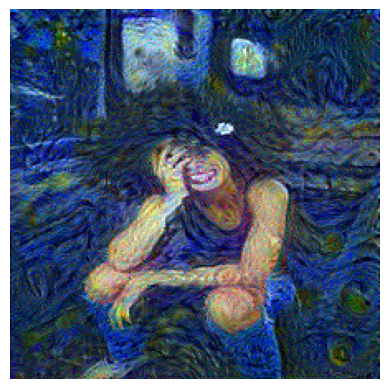

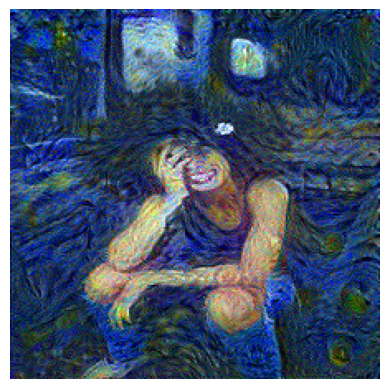

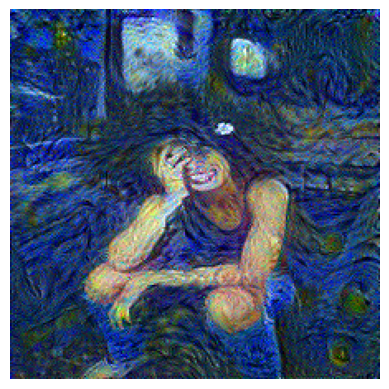

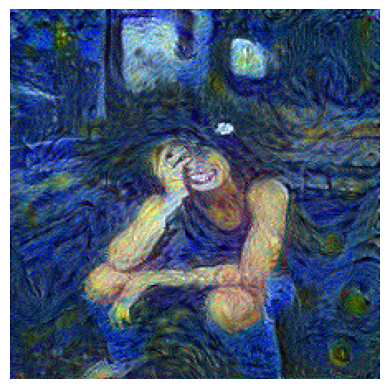

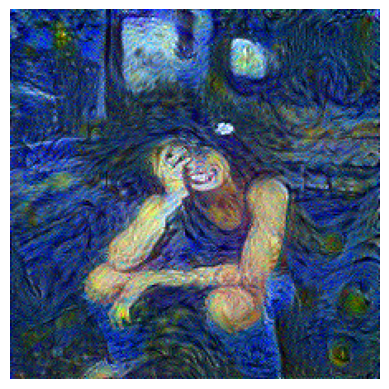

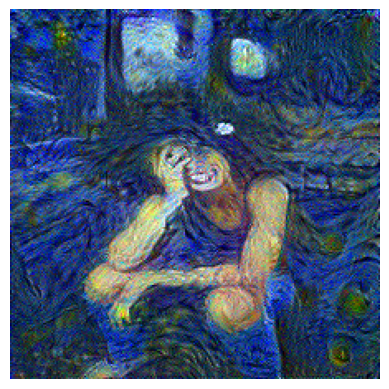

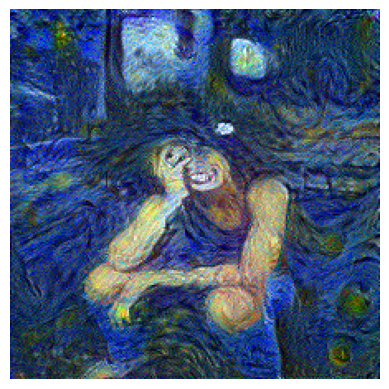

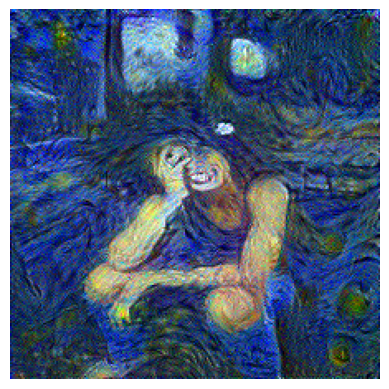

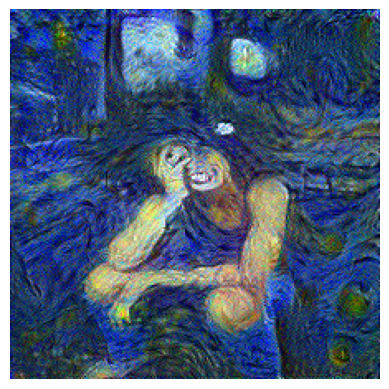

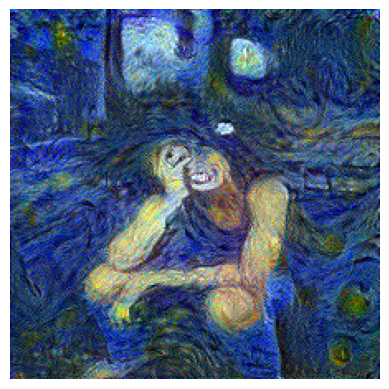

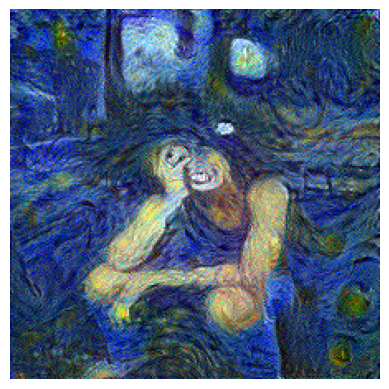

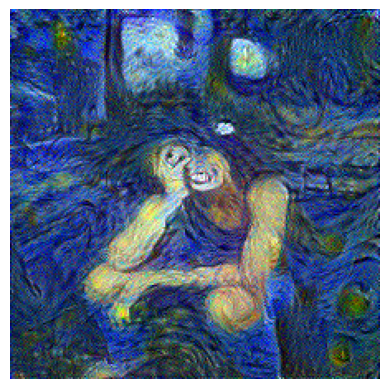

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess your content and style images
def load_and_preprocess_image(image_path):
    # Your image loading and preprocessing code here
    img = Image.open(image_path).resize((224,224)).convert('RGB')
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

content_image = load_and_preprocess_image('../data/normal2.jpg')
style_image = load_and_preprocess_image('../data/style20.png')

# Initialize generated_image with the content image
generated_image = tf.Variable(content_image)  # Ensure it's a trainable variable

# Load VGG19 model for style transfer
model = VGG19(include_top=False, weights='imagenet')
for layer in model.layers:
    print(layer.name)

# Updated content and style layers
content_layers = ['block4_conv2', 'block5_conv3']  # More mid-level content features
style_layers = ['block1_conv1', 'block2_conv1','block2_conv2', 'block3_conv3', 'block4_conv3','block5_conv3']  # Added layers for richer style textures

# Weight parameters
content_weight = 1e0  # Lowered to allow more style influence
style_weight = 1e6    # Increased for more style texture

# Learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)  # Adjusted for experimentation


# Create a model that outputs the desired layers
def get_model(output_layers):
    outputs = [model.get_layer(layer).output for layer in output_layers]
    return tf.keras.Model(inputs=model.input, outputs=outputs)

# Create a model for content and style
content_model = get_model(content_layers)
style_model = get_model(style_layers)

# Define function to get features from the models
def get_features(model, image):
    # Forward pass through the model to get the features
    features = model(image)
    return features

# Get content and style features
content_features = get_features(content_model, content_image)
style_features = get_features(style_model, style_image)

# Define content and style loss functions
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def gram_matrix(tensor):
    # Calculate the Gram matrix for style representation
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    return tf.matmul(tf.transpose(a), a)

def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))
# Add Total Variation Loss to smooth the image
def total_variation_loss(image):
    return tf.image.total_variation(image)



@tf.function
def train_step():
    with tf.GradientTape() as tape:
         # Get generated features
        generated_content_features = get_features(content_model, generated_image)
        generated_style_features = get_features(style_model, generated_image)

        # Compute content and style loss
        c_loss = content_loss(content_features[0], generated_content_features[0])
        s_loss = sum(style_loss(style_features[j], generated_style_features[j]) for j in range(len(style_layers)))

         # Ensure all components are of the same type (float32)
        c_loss = tf.cast(c_loss, tf.float32)
        s_loss = tf.cast(s_loss, tf.float32)
        tv_loss = tf.cast(total_variation_loss(generated_image), tf.float32)
        # Add total variation loss for smoothness
        total_loss = content_weight * c_loss + style_weight * s_loss + 1e-6 * tv_loss

    grads = tape.gradient(total_loss, generated_image)
    grads = tf.clip_by_value(grads, -1.0, 1.0)
    optimizer.apply_gradients([(grads, generated_image)])


# Run your optimization loop
for i in range(1000):  # Reduce iterations to test faster
    train_step()
    if i % 50 == 0:
        output_image = generated_image.numpy().squeeze()
        output_image = np.clip(output_image * 255, 0, 255).astype('uint8')
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
        
    

# # After optimization, convert generated_image back to displayable format
# output_image = generated_image.numpy().squeeze()
# output_image = np.clip(output_image * 255, 0, 255).astype('uint8')

# # Display the output image
# import matplotlib.pyplot as plt

# plt.imshow(output_image)
# plt.axis('off')
# plt.show()
